In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str      # 사용자 질문
    answer: str     # 세율
    tax_base_equation: str # 과세표준 계산 수식
    tax_deduction: str # 공제액
    market_ratio: str # 공정시장가액비율
    tax_base: str   # 과세표준 계산

graph_builder = StateGraph(AgentState)

In [ ]:
import os 

from langchain_chroma import Chroma
from langchain_openai import AzureOpenAIEmbeddings

# embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')
embedding_function = AzureOpenAIEmbeddings(
    model='text-embedding-3-large',
    azure_endpoint=os.getenv('AZURE_OPENAI_EMBEDDING_ENDPOINT'),
    api_key=os.getenv('AZURE_OPENAI_EMBEDDING_API_KEY')
)
vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'real_estate_tax',
    persist_directory='./real_estate_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [ ]:
query = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'

In [ ]:
tax_base_retrieval_chain = (
    {'context': retriever, 'question': RunnablePassthrough()} 
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

tax_base_equation_prompt = ChatPromptTemplate.from_messages([
    ('system', '사용자의 질문에서 과세표준을 계산하는 방법을 수식으로 나타내주세요. 부연설명 없이 수식만 리턴해주세요'),
    ('human', '{tax_base_equation_information}')
])

tax_base_equation_chain = (
    {'tax_base_equation_information': RunnablePassthrough()}
    | tax_base_equation_prompt
    | llm
    | StrOutputParser()
)

tax_base_chain = {'tax_base_equation_information' : tax_base_retrieval_chain} | tax_base_equation_chain

def get_tax_base_equation(state: AgentState) -> AgentState:
    """
    종합부동산세 과세표준을 계산하는 수식을 가져옵니다.
    `node`로 활용되기 때문에 `state`를 인자로 받지만, 
    고정된 기능을 수행하기 때문에 `state`를 활용하지는 않습니다.

    Args:
        state (AgentState): 현재 에이전트의 상태를 나타내는 객체입니다.

    Returns:
        AgentState: 'tax_base_equation' 키를 포함하는 새로운 `state`를 반환합니다.
    """
    # 과세표준을 계산하는 방법을 묻는 질문을 정의합니다.
    tax_base_equation_question = '주택에 대한 종합부동산세 계산시 과세표준을 계산하는 방법을 수식으로 표현해서 알려주세요'
    
    # tax_base_chain을 사용하여 질문을 실행하고 결과를 얻습니다.
    tax_base_equation = tax_base_chain.invoke(tax_base_equation_question)
    
    # state에서 'tax_base_equation' 키에 대한 값을 반환합니다.
    return {'tax_base_equation': tax_base_equation}

In [ ]:
tax_deduction_chain = (
    {'context': retriever, 'question': RunnablePassthrough()} 
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

def get_tax_deduction(state: AgentState) -> AgentState:
    """
    종합부동산세 공제금액에 관한 정보를 가져옵니다.
    `node`로 활용되기 때문에 `state`를 인자로 받지만, 
    고정된 기능을 수행하기 때문에 `state`를 활용하지는 않습니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        AgentState: 'tax_deduction' 키를 포함하는 새로운 state를 반환합니다.
    """
    # 공제금액을 묻는 질문을 정의합니다.
    tax_deduction_question = '주택에 대한 종합부동산세 계산시 공제금액을 알려주세요'
    
    # tax_deduction_chain을 사용하여 질문을 실행하고 결과를 얻습니다.
    tax_deduction = tax_deduction_chain.invoke(tax_deduction_question)
    
    # state에서 'tax_deduction' 키에 대한 값을 반환합니다.
    return {'tax_deduction': tax_deduction}

In [ ]:
from langchain_community.tools import TavilySearchResults
from datetime import date

tavily_search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
    ('system', f'아래 정보를 기반으로 공정시장 가액비율을 계산해주세요\n\nContext:\n{{context}}'),
    ('human', '{query}')
])

def get_market_ratio(state: AgentState) -> AgentState:
    """
    web 검색을 통해 주택 공시가격에 대한 공정시장가액비율을 가져옵니다.
    `node`로 활용되기 때문에 `state`를 인자로 받지만, 
    고정된 기능을 수행하기 때문에 `state`를 활용하지는 않습니다.
    
    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        AgentState: 'market_ratio' 키를 포함하는 새로운 state를 반환합니다.
    """
    # 오늘 날짜에 해당하는 공정시장가액비율을 묻는 쿼리를 정의합니다.
    query = f'오늘 날짜:({date.today()})에 해당하는 주택 공시가격 공정시장가액비율은 몇%인가요?'
    
    # tavily_search_tool을 사용하여 쿼리를 실행하고 컨텍스트를 얻습니다.
    context = tavily_search_tool.invoke(query)
    
    # tax_market_ratio_chain을 구성하여 쿼리와 컨텍스트를 처리합니다.
    tax_market_ratio_chain = (
        tax_market_ratio_prompt
        | llm
        | StrOutputParser()
    )
    
    # tax_market_ratio_chain을 사용하여 시장 비율을 계산합니다.
    market_ratio = tax_market_ratio_chain.invoke({'context': context, 'query': query})
    
    # state에서 'market_ratio' 키에 대한 값을 반환합니다.
    return {'market_ratio': market_ratio}

answer == {'answer': 'Bean Factory는 스프링 프레임워크의 가장 기본적인 컨테이너로, 빈(객체)을 관리하는데 주로 사용됩니다. Application Context는 Bean Factory을 확장한 것으로, 국제화, 이벤트 전파, 애플리케이션 레벨의 설정 등을 추가로 지원하며, 보다 풍부한 기능을 제공합니다. 따라서 실용적인 개발에서는 보통 Application Context를 사용합니다.'}


In [ ]:
tax_base_calculation_prompt = ChatPromptTemplate.from_messages(
    [
        ('system',"""
주어진 내용을 기반으로 과세표준을 계산해주세요

과세표준 계산 공식: {tax_base_equation}
공제금액: {tax_deduction}
공정시장가액비율: {market_ratio}"""),
        ('human', '사용자 주택 공시가격 정보: {query}')
    ]
)

def calculate_tax_base(state: AgentState) -> AgentState:
    """
    주어진 state에서 과세표준을 계산합니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        AgentState: 'tax_base' 키를 포함하는 새로운 state를 반환합니다.
    """
    # state에서 필요한 정보를 추출합니다.
    tax_base_equation = state['tax_base_equation']
    tax_deduction = state['tax_deduction']
    market_ratio = state['market_ratio']
    query = state['query']
    
    # tax_base_calculation_chain을 구성하여 과세표준을 계산합니다.
    tax_base_calculation_chain = (
        tax_base_calculation_prompt
        | llm
        | StrOutputParser()
    )
    
    # tax_base_calculation_chain을 사용하여 과세표준을 계산합니다.
    tax_base = tax_base_calculation_chain.invoke({
        'tax_base_equation': tax_base_equation,
        'tax_deduction': tax_deduction,
        'market_ratio': market_ratio,
        'query': query
    })

    # state에서 'tax_base' 키에 대한 값을 반환합니다.
    return {'tax_base': tax_base}

In [ ]:
tax_rate_calculation_prompt = ChatPromptTemplate.from_messages([
    ('system', '''당신은 종합부동산세 계산 전문가입니다. 아래 문서를 참고해서 사용자의 질문에 대한 종합부동산세를 계산해주세요

종합부동산세 세율:{context}'''),
    ('human', '''과세표준과 사용자가 소지한 주택의 수가 아래와 같을 때 종합부동산세를 계산해주세요

과세표준: {tax_base}
주택 수:{query}''')
])

def calculate_tax_rate(state: AgentState):
    """
    주어진 state에서 세율을 계산합니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        dict: 'answer' 키를 포함하는 새로운 state를 반환합니다.
    """
    # state에서 필요한 정보를 추출합니다.
    query = state['query']
    tax_base = state['tax_base']
    
    # retriever를 사용하여 쿼리를 실행하고 컨텍스트를 얻습니다.
    context = retriever.invoke(query)
    
    # tax_rate_chain을 구성하여 세율을 계산합니다.
    tax_rate_chain = (
        tax_rate_calculation_prompt
        | llm
        | StrOutputParser()
    )
    
    # tax_rate_chain을 사용하여 세율을 계산합니다.
    tax_rate = tax_rate_chain.invoke({
        'context': context, 
        'tax_base': tax_base, 
        'query': query
    })

    # state에서 'answer' 키에 대한 값을 반환합니다.
    return {'answer': tax_rate}

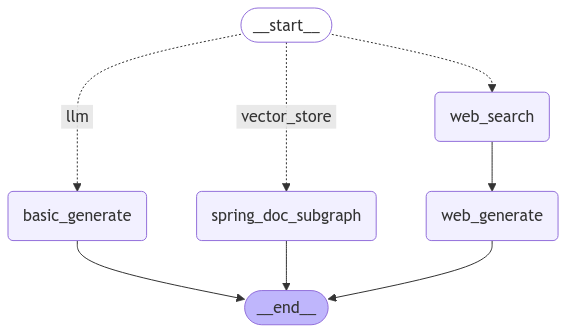

In [ ]:
graph_builder.add_node('get_tax_base_equation', get_tax_base_equation)
graph_builder.add_node('get_tax_deduction', get_tax_deduction)
graph_builder.add_node('get_market_ratio', get_market_ratio)
graph_builder.add_node('calculate_tax_base', calculate_tax_base)
graph_builder.add_node('calculate_tax_rate', calculate_tax_rate)

In [ ]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'get_tax_base_equation')
graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'get_market_ratio')
graph_builder.add_edge('get_tax_base_equation', 'calculate_tax_base')
graph_builder.add_edge('get_tax_deduction', 'calculate_tax_base')
graph_builder.add_edge('get_market_ratio', 'calculate_tax_base')
graph_builder.add_edge('calculate_tax_base', 'calculate_tax_rate')
graph_builder.add_edge('calculate_tax_rate', END)

web search results == {results}


{'query': '웹상에서 사용하는 통신 규약은 무엇이 있나요?',
 'context': [{'url': 'https://velog.io/@river-m/HTTP와-HTTPS-웹의-기본-통신-규약',
   'content': '인터넷에서 웹 페이지를 열거나 정보를 주고받을 때 사용하는 기본적인 규약이 바로 HTTP(Hypertext Transfer Protocol)와 HTTPS(Hypertext Transfer Protocol Secure)이다. 그럼 이 둘의 차이점은 무엇이고, 왜 중요한지 ... HTTP와 HTTPS는 웹의 통신 규약의 기본이며, 그 중 HTTPS는 웹에서'},
  {'url': 'https://uknew.co/통신-프로토콜이란-인터넷에서-자주-언급되는-protocol-종/',
   'content': '통신 프로토콜(communication protocol:통신 규약)은 컴퓨터나 원거리 통신 장비 사이에서 메시지를 주고 받는 양식과 규칙 체계입니다. 네트워크에서 통신할 때 규약으로 프로토콜이라는 용어를 사용합니다. 통신하기 위한 규칙이 통신 프로토콜이란 것을 알 수'},
  {'url': 'https://km713.tistory.com/51',
   'content': '프로토콜(Protocol) 통신 프로토콜 또는 통신 규약은 컴퓨터나 원거리 통신 장비 사이에서 메시지를 주고 받는 양식과 규칙의 체계이다. 즉 통신 규약 및 약속이다. 프로토콜의 기본 요소 구문(Syntax) : 전송하고자 하는 데이터의 형식(Format), 부호화(Coding), 신호 레벨(Signal Level) 등을 규정의미(Semantics) : 두'}],
 'answer': '웹상에서 사용하는 통신 규약에는 HTTP(Hypertext Transfer Protocol)와 HTTPS(Hypertext Transfer Protocol Secure)가 있습니다. HTTP와 HTTPS는 웹의 기본적인 통신 규약으로, HTTPS는 보안이 강화된 버전입니다.'}

In [ ]:
graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
initial_state = {'query': query}
graph.invoke(initial_state)